# Required package

In [163]:
import string
import math
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import defaultdict, Counter
import numpy as np
import pickle
import pandas as pd
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/My Drive/data/preprocessed-data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [4]:
df_lyrics = pd.read_csv(f"{folder_path}/song_tokenized_lyrics.csv")
df_metadata = pd.read_csv(f"{folder_path}/song_metadata.csv")
df_genre = df_metadata.drop(columns=['artist', 'name', 'popularity', 'release_date','explicit', 'duration_ms', 'featured_artists'])
# df_genre.head()
# df_metadata.head()

df_music = pd.merge(df_genre,df_lyrics,on='spotify_id')
df_music = df_music.drop(columns=['spotify_id','Unnamed: 0'])

# drop song without lyrics
df_music = df_music[df_music['lyrics'] != '[]']
df_music.drop_duplicates(subset=['lyrics'], inplace=True)

<ipython-input-4-83722b0f6109>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_music.drop_duplicates(subset=['lyrics'], inplace=True)


In [5]:
list(df_music['genre'].value_counts())[:10]
# get top 30 genre since some genre only have 1-2 songs
top_30_genres = df_music['genre'].value_counts()
# top_10_genre = top_10_genre.index[:10]
top_30_genres.iloc[0:30]

rock                 769
pop                  753
indie                532
soul                 373
alternative          297
folk                 281
hip-hop              242
acoustic             164
classic rock         159
singer-songwriter    143
electronic           131
country              126
jazz                 123
alternative rock     120
rap                  107
soundtrack           105
indie rock           101
punk                  89
hard rock             68
new wave              64
progressive rock      62
hip hop               56
blues                 52
metal                 47
emo                   45
post-punk             44
shoegaze              44
piano                 42
industrial            40
r&b                   40
Name: genre, dtype: int64

In [6]:
# get datafram only in top_30_genres
df_music_top_30 = df_music[df_music['genre'].isin(top_30_genres.index[:30])]
df_music_top_30['genre'].unique()

array(['rap', 'metal', 'hip-hop', 'singer-songwriter', 'punk',
       'classic rock', 'rock', 'pop', 'post-punk', 'alternative rock',
       'hard rock', 'electronic', 'hip hop', 'alternative', 'country',
       'industrial', 'soul', 'soundtrack', 'indie', 'emo', 'folk',
       'indie rock', 'piano', 'new wave', 'jazz', 'blues', 'r&b',
       'shoegaze', 'acoustic', 'progressive rock'], dtype=object)

In [7]:

# def tokenize(lyrics):
#     # lines = lyrics.split('\n')
#     words = word_tokenize(lyrics)
#     print(words[:100])
#     print(len(words))



# tokenize(rock[0])
# len(genre_tokenLyrics['rock'])

## Tokenization

In [8]:
def clean_text(song):
    song = re.sub('\'m', ' am', song)
    song = re.sub('\'ve', ' have', song)
    song = re.sub('\'d ', ' would', song)
    song =re.sub('\'ll', ' will', song)
    song = re.sub('\'s', ' is', song)
    song = re.sub('\'re', ' are', song)

    song = song.lower()
    return song

genre_lyrics = defaultdict(list)

for genre, lyrics in zip(df_music_top_30['genre'], df_music_top_30['lyrics']):
    genre_lyrics[genre].append(lyrics)

rock = genre_lyrics['rock']

genre_tokenLyrics = defaultdict(list)
for genre, lyrics in genre_lyrics.items():
    tokenized_lyric = []
    for song in lyrics:
        song = clean_text(song)
        lines = song.split('\n')
        for line in lines:
            words = word_tokenize(line)
            bracket_sent = []
            for i in range(len(words)+2):
                if i == 0:
                    bracket_sent.append('<s>')
                elif i == len(words)+1:
                    bracket_sent.append('</s>')
                else:
                    bracket_sent.append(words[i-1])
            # print(bracket_sent)
            tokenized_lyric.append(bracket_sent)
    # if genre == 'rock':
    #     print(tokenized_lyric[:100])
    #     print(len(tokenized_lyric))
    genre_tokenLyrics[genre] = tokenized_lyric
genre_tokenLyrics['rock'][0]

['<s>', '[', 'verse', '1', ']', '</s>']

# Create DataFrame

In [74]:
def pad_sentence(sentence):
    padding_sentence = np.full(50, 'pad', dtype='U50')
    length = len(sentence)
    if length < 50:
        padding_sentence[(50-length):] = sentence
    else:
        padding_sentence = sentence[(length-50):]
    return padding_sentence

# x = ['iaaa','iaaa','iaaa','iiaaa','iiaaa','iiaaa','iiaaa','iiaaa','iiaaa','iiaaa','iiaaa','iiaaa']
# y = pad_sentence(x)
# print(y)

In [79]:
genres = []
input_lyrics = []
output_words = []

for genre, lyrics in genre_tokenLyrics.items():
    for sentence in lyrics:
        if len(sentence) > 1:
            sentence = pad_sentence(sentence)
            input_sentence = sentence[:-2]
            output_word = sentence[-2]

            genres.append(genre)
            input_lyrics.append(input_sentence)
            output_words.append(output_word)


df_music_cleaned = pd.DataFrame({
    'genre': genres,
    'input_lyrics': input_lyrics,
    'output_word': output_words
})

In [80]:
# output_words[0] in string.punctuation
output_words[0]
# len(output_words)

']'

In [82]:
input_lyrics[0]

array(['pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad',
       'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad',
       'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad',
       'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad',
       'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', '<s>', '[',
       'intro', ':', 'eminem'], dtype='<U50')

In [81]:
genre_tokenLyrics['rap'][0]

['<s>', '[', 'intro', ':', 'eminem', ']', '</s>']

In [12]:
x = 0
for word in output_words:
    if word in string.punctuation:
        x += 1
print(x)

61921


In [83]:
df_music_cleaned

,genre,input_lyrics,output_word
0,rap,"[pad, pad, pad, pad, pad, pad, pad, pad, pad, ...",]
1,rap,"[pad, pad, pad, pad, pad, pad, pad, pad, pad, ...",tired
2,rap,"[pad, pad, pad, pad, pad, pad, pad, pad, pad, ...",left
3,rap,"[pad, pad, pad, pad, pad, pad, pad, pad, pad, ...",weak
4,rap,"[pad, pad, pad, pad, pad, pad, pad, pad, pad, ...",left
...,...,...,...
289998,progressive rock,"[pad, pad, pad, pad, pad, pad, pad, pad, pad, ...",<s>
289999,progressive rock,"[pad, pad, pad, pad, pad, pad, pad, pad, pad, ...",]
290000,progressive rock,"[pad, pad, pad, pad, pad, pad, pad, pad, pad, ...",ho-ho-home
290001,progressive rock,"[pad, pad, pad, pad, pad, pad, pad, pad, pad, ...",<s>


# DataSet

In [84]:
word_counts = Counter()
for _, tokenLyric in genre_tokenLyrics.items():
    for song in tokenLyric:
        word_counts.update(song)
    words = list(word_counts.keys())
    word_to_index = {w: idx for idx, w in enumerate(words)}
    index_to_word = {idx: w for idx, w in enumerate(words)}

# some words can't be found in Dictionary
word_to_index["<UNK>"] = len(word_to_index)
# index_to_word[len(word_to_index)] = ["UNK"]
index_to_word[word_to_index["<UNK>"]] = "<UNK>"

# word_to_index
genres = genre_tokenLyrics.keys()
genre_to_index = {genre: idx for idx, genre in enumerate(genres)}
index_to_genre = {idx: genre for idx, genre in enumerate(genres)}

# genre_to_index

In [85]:
class LyricsDataset(Dataset):
    def __init__(self, dataframe, word_to_index, genre_to_index):
        self.dataframe = dataframe
        self.word_to_index = word_to_index
        self.genre_to_index = genre_to_index

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        genre = self.genre_to_index[row['genre']]
        input_lyrics = [self.word_to_index.get(word, self.word_to_index["<UNK>"]) for word in row['input_lyrics']]
        output_word = self.word_to_index.get(row['output_word'], self.word_to_index["<UNK>"])
        return torch.tensor(input_lyrics, dtype=torch.long), torch.tensor(genre, dtype=torch.long), torch.tensor(output_word, dtype=torch.long)

train_dataset = LyricsDataset(df_music_cleaned, word_to_index, genre_to_index)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Train model

In [86]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [87]:
class LyricsLSTM(nn.Module):
    def __init__(self, vocab_size, genre_size, embedding_dim, hidden_dim, output_dim):
        super(LyricsLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.genre_embedding = nn.Embedding(genre_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, lyrics, genre):
        lyrics_embedded = self.embedding(lyrics)
        genre_embedded = self.genre_embedding(genre)
        combined = lyrics_embedded + genre_embedded.unsqueeze(1)
        lstm_out, _ = self.lstm(combined)
        out = self.fc(lstm_out[:, -1, :])
        return out

vocab_size = len(word_to_index)
genre_size = 30
embedding_dim = 128
hidden_dim = 128
output_dim = vocab_size
model = LyricsLSTM(vocab_size, genre_size, embedding_dim, hidden_dim, output_dim).to(device)
print(model)

LyricsLSTM(
  (embedding): Embedding(31631, 128)
  (genre_embedding): Embedding(30, 128)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=31631, bias=True)
)


## epoch 20

100%|██████████| 4532/4532 [01:08<00:00, 65.89it/s]


Epoch 1/20, Loss: 4.4472


100%|██████████| 4532/4532 [01:07<00:00, 67.22it/s]


Epoch 2/20, Loss: 3.4339


100%|██████████| 4532/4532 [01:06<00:00, 67.76it/s]


Epoch 3/20, Loss: 2.8634


100%|██████████| 4532/4532 [01:09<00:00, 65.05it/s]


Epoch 4/20, Loss: 2.4751


100%|██████████| 4532/4532 [01:07<00:00, 67.59it/s]


Epoch 5/20, Loss: 2.1829


100%|██████████| 4532/4532 [01:07<00:00, 67.40it/s]


Epoch 6/20, Loss: 1.9530


100%|██████████| 4532/4532 [01:09<00:00, 65.57it/s]


Epoch 7/20, Loss: 1.7613


100%|██████████| 4532/4532 [01:07<00:00, 67.05it/s]


Epoch 8/20, Loss: 1.6014


100%|██████████| 4532/4532 [01:07<00:00, 66.99it/s]


Epoch 9/20, Loss: 1.4660


100%|██████████| 4532/4532 [01:07<00:00, 67.07it/s]


Epoch 10/20, Loss: 1.3480


100%|██████████| 4532/4532 [01:08<00:00, 65.86it/s]


Epoch 11/20, Loss: 1.2465


100%|██████████| 4532/4532 [01:07<00:00, 66.75it/s]


Epoch 12/20, Loss: 1.1580


100%|██████████| 4532/4532 [01:07<00:00, 67.15it/s]


Epoch 13/20, Loss: 1.0792


100%|██████████| 4532/4532 [01:10<00:00, 64.69it/s]


Epoch 14/20, Loss: 1.0123


100%|██████████| 4532/4532 [01:07<00:00, 67.10it/s]


Epoch 15/20, Loss: 0.9519


100%|██████████| 4532/4532 [01:07<00:00, 67.51it/s]


Epoch 16/20, Loss: 0.8981


100%|██████████| 4532/4532 [01:09<00:00, 65.31it/s]


Epoch 17/20, Loss: 0.8521


100%|██████████| 4532/4532 [01:08<00:00, 66.17it/s]


Epoch 18/20, Loss: 0.8079


100%|██████████| 4532/4532 [01:07<00:00, 66.93it/s]


Epoch 19/20, Loss: 0.7709


100%|██████████| 4532/4532 [01:09<00:00, 65.53it/s]


Epoch 20/20, Loss: 0.7368


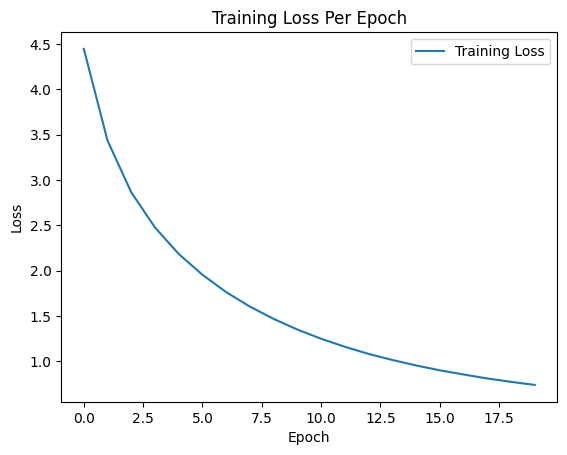

In [89]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    total_loss_per_epoch = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for lyrics, genre, target in tqdm(train_loader):
            lyrics = lyrics.to(device)
            genre = genre.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            outputs = model(lyrics, genre)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')
        total_loss_per_epoch.append(avg_loss)


    plt.plot(total_loss_per_epoch, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Per Epoch')
    plt.legend()
    plt.show()


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20
train_model(model, train_dataloader, criterion, optimizer, num_epochs)

## Pickle model

In [91]:
with open('lyrics_model_20epoch.pkl', 'wb') as f:
    pickle.dump(model, f)

## epoch 30

100%|██████████| 4532/4532 [01:08<00:00, 66.14it/s]


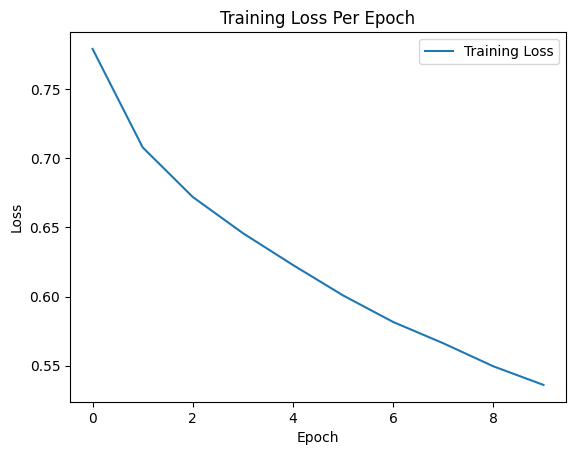

In [92]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    total_loss_per_epoch = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for lyrics, genre, target in tqdm(train_loader):
            lyrics = lyrics.to(device)
            genre = genre.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            outputs = model(lyrics, genre)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        # print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')
        total_loss_per_epoch.append(avg_loss)


    plt.plot(total_loss_per_epoch, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Per Epoch')
    plt.legend()
    plt.show()


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
train_model(model, train_dataloader, criterion, optimizer, num_epochs)

## Pickle model

In [94]:
with open('lyrics_model_30epoch.pkl', 'wb') as f:
    pickle.dump(model, f)

# Generate words

In [198]:
def softmax_sampling(logits, temperature=1.0):
    if logits.dim() == 1:
        logits = logits.unsqueeze(0)
    probabilities = F.softmax(logits / temperature, dim=-1)
    next_word_idx = torch.multinomial(probabilities, num_samples=1)
    return next_word_idx.item()

seed = 'i love you '
genre_seed = 'soul'
temperature = 1.0

model.eval()

current_text = [word_to_index.get(word, word_to_index["<UNK>"]) for word in seed.split()]
genre_index = genre_to_index[genre_seed]

input_seq = torch.tensor([current_text], dtype=torch.long).to(device)
genre_seq = torch.tensor([genre_index], dtype=torch.long).to(device)

with torch.no_grad():
    output = model(input_seq, genre_seq)
    # print(output[0])
    logits = output[0]
    next_word_idx = softmax_sampling(logits, temperature)
    # print(next_word_idx)

next_word = index_to_word.get(next_word_idx, "<UNK>")
print("Next word:", next_word)

Next word: baby


# Generator Lyrics

In [200]:
def show_lyrics(generated_lyrics, genre, seed):
    generated_lyrics = generated_lyrics.split()
    print(f"Genre: {genre}")
    print(f"Seed: {seed}")
    rounds = math.ceil(len(generated_lyrics) / 50)
    for i in range(rounds):
        if i == rounds - 1:
            print(' '.join(generated_lyrics[i*50:]))
            # print(generated_lyrics[i*100:])
            print('\n')
        else:
            print(' '.join(generated_lyrics[i*50 : (i+1)*50]))

# show_lyrics(generated_lyrics_soul, genre1, seed_text)


In [204]:
def generate_lyrics(model, seed, genre, word_to_index, index_to_word, genre_to_index, max_length=1000, max_sentence_length=50, temperature=1.0):
    model.eval()

    generated_lyrics = seed
    current_sentence_length = 0
    current_text = [word_to_index.get(word, word_to_index["<UNK>"]) for word in seed.split()]
    genre_index = genre_to_index[genre]

    for _ in range(max_length):
        if current_sentence_length >= max_sentence_length:
            current_text = [word_to_index.get("<s>", word_to_index["<UNK>"])]
            current_sentence_length = 0

        input_seq = torch.tensor([current_text], dtype=torch.long).to(device)
        genre_seq = torch.tensor([genre_index], dtype=torch.long).to(device)

        with torch.no_grad():
            output = model(input_seq, genre_seq)
            logits = output[0]
            next_word_idx = softmax_sampling(logits, temperature)

        next_word = index_to_word.get(next_word_idx, "<UNK>")
        generated_lyrics += " " + next_word
        current_text.append(next_word_idx)
        current_sentence_length += 1

        if next_word == "</s>" or len(generated_lyrics.split()) >= max_length:
            break

    return generated_lyrics

seed_text = "sun will shine again"
genre1 = "soul"
genre2 = "rock"
genre3 = 'rap'
generated_lyrics_soul = generate_lyrics(model, seed_text, genre1, word_to_index, index_to_word, genre_to_index, max_length=500, max_sentence_length=50, temperature=1.0)
generated_lyrics_rock = generate_lyrics(model, seed_text, genre2, word_to_index, index_to_word, genre_to_index, max_length=500, max_sentence_length=50, temperature=1.0)
generated_lyrics_rap = generate_lyrics(model, seed_text, genre2, word_to_index, index_to_word, genre_to_index, max_length=500, max_sentence_length=50, temperature=1.0)

show_lyrics(generated_lyrics_soul, genre1, seed_text)
show_lyrics(generated_lyrics_rock, genre2, seed_text)
show_lyrics(generated_lyrics_rap, genre3, seed_text)

Genre: soul
Seed: sun will shine again
sun will shine again ? yeah '' leave you leave me lonely up ! '' hide now ... next summer rain ... sign here clap like me ? hoo hoo hoo hoo hoo hoo hoo hoo hoo hoo hoo hoo hoo hoo hoo hoo hoo hoo hoo hoo hoo hoo
hoo hoo hoo hoo no regrets need involved college for town ? '' uhh loud ! '' yeah there mars tonight 'em now woo anyhow uhh uhh uhh uhh uhh uhh uhh uhh uhh uhh uhh uhh uhh uhh flight calls ends change that guy over again ! will go
go '' '' again make nice bed tasted town bust glow ya down down down outside ! away task ! ! '' pumps teeth '' world see you yeah ? '' bruises arms card strong sunrise by light on me tonight tour tonight up you down within and key another
chance behave still believes paris alright ... ) oh ... oh hey oh ) oh then i did keep ... ) did smiles to me never knew me now now now now ' on fire before before last night nice 'cause ah-yeah-yeah-yeah-yeah-yeah words dirty heart is breaking kisses there is
disguise girl drea